# How to implement NLP preprocessing techniques in Python

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scaleapi/dev-blog/blob/main/exchange-nlu-text-preprocessing/text_preprocessing.ipynb)


**Subtitle**: Here are the preprocessing and transformation stages you need to follow when working with unstructured text in Python. 

**Summary (meta description)**: Here's a step-by-step guide to using NLP preprocessing techniques in Python to convert unstructured text data to a structured numerical format using Python.

**Byline**: Mehreen Saeed

**Audience**:  AI/ML Engineers, Researchers and SMEs

***Keywords**: Natural Language Processing, Python, Unstructured Data 

Most of the textual data that we encounter in day to day life is unstructured. It has to be preprocessed, cleaned, and converted to a numerical format for input to a machine learning algorithm. So what's the best way to do that?

In [A Guide to Text Preprocessing Techniques for NLP](https://exchange.scale.com/public/blogs/preprocessing-techniques-in-nlp-a-guide), I discussed the basics of the text preprocessing pipeline. This time, I focus on how to use various methods for the numeric representing and transformation of text data using Python. I'll cover the following:

- Text cleaning and dictionary construction in Python.
- Representing a text document using a vector of statistical metrics.
  - Bag of words (binary and count based).
  - Term frequency.
  - Inverse document frequency.
  - Term frequency-Inverse document frequency.
- Conversion of text documents to vectors of statistical metrics in Python.  
- Representing a text document using embedding matrices or vectors in Python.
  - Random embeddings.
  - Sinusoidal embeddings.
  - Loading pre-trained embeddings.

You can use these methods for further clustering, classification, labeling, or other tasks involving text data.


## The Import Section

Let's start by adding the following import section to the code. The inline comments explain the main purpose of the imported library.

In [ ]:
# Preprocessing layers/modules
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Embedding, Layer

# For pre-trained embeddings
import tensorflow_hub as hub

# For datasets
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras import utils
from tensorflow.data import Dataset

# Miscellaneous tasks
from tensorflow import string, float32
from tensorflow import constant, convert_to_tensor

# For math
import numpy as np

# For plotting
import matplotlib.pyplot as plt

## A Note on Terminology 

In this tutorial, I have illustrated some algorithms and methods using a toy example as well as the  [20 newsgroup text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). I'll be using the following notations:

- **Text Corpus**: The entire text used in the preprocessing and training stages. A text corpus comprises multiple documents.
- **Document**: A set of sentences, grouped into a document. A document can be a single news item, an entire book, a magazine, a single email, or just a simple sentence.
- **Token/Word**: A word of the English language. It is the smallest meaningful entity that we'll process.
- **The prefix toy**: All variables related to the toy example with just two documents are prefixed by the word `toy`. 
- **The prefix docs**: All variables related to the Newsgroup dataset are prefixed by the word `docs`.

Also note that the output you see in this tutorial won't necessarily match the output you'll get because of the random/stochastic nature of the algorithms involved.

## The Newsgroup Dataset

The scikit-learn library includes the 20 newsgroup text dataset that consists of around 18,000 newsgroup posts, each corresponding to one of 20 newsgroup topics. This dataset can be used for a number of tasks, such as document clustering, document labeling, or document classification. I'll use this dataset to illustrate how you can convert sentences to sequences of numbers, and further convert these sequences to word embeddings. For now, two categories are sufficient to show these methods, so I am loading only the documents from the alt.atheism and comp.graphics categories.

The code below reads the training subset using `fetch_20newsgroups()`, and prints some statistics. An example document is also printed below.

In [ ]:
categories = ['alt.atheism', 'comp.graphics']
# Load the training dataset while removing headers, footers and quotes
train_dataset = fetch_20newsgroups(subset='train', categories=categories, 
                                   remove=('headers', 'footers', 'quotes'),
                                   random_state=0)
train_X, train_Y = (train_dataset.data, train_dataset.target)

# Target classes
newsgroup_names = train_dataset.target_names

#Print statistics
print('Total documents in subset of Newsgroups corpus: ', len(train_X))
print('\nAn example document from category:', newsgroup_names[train_Y[0]])
print(train_X[0])

Total documents in subset of Newsgroups corpus:  1064

An example document from category: comp.graphics
Hi !

If you want to have Soft-Scrolling on your VGA, you have to change some 
intern registers of the CRTC. But it is a little bit difficult to explain, 
so I would suggest, you take a look at "The Programming of the 
EGA/VGA-Adapter" by Addison-Wesley. You will find all useful descriptions 
for every available VGA-Register.

-Boris



## Cleaning Text and Creating a Dictionary With `TextVectorization` Layer in Keras 

One of the first steps involved in text-processing is text cleaning, which can involve the following:

- Convert the text to lowercase.
- Strip the text of its punctuation.
- Split the text into a sequence of tokens. (For the purposes of this tutorial, we'll consider a single word to be a token.)
- Build a dictionary of unique words.
- Replace each word with its corresponding dictionary index.

Fortunately, the Keras library comes with a layer called [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) that does all this in just one function call. Earlier TensorFlow versions came with a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class that could be used to carry out all these tasks. However, this class is now deprecated and the `TextVectorization` layer should be used instead.

You can initialize the `TextVectorization` layer by specifying a `standardize` parameter. By default, the value of this parameter is set to `lower_and_strip_punctuation`. This implies that, by default, the layer will automatically convert the input text to lowercase and remove all punctuation from it. Another important parameter, `split`, with a default value of `whitespace`, tells the `TextVecorization` layer to split text based on whitespace characters. For more complex tasks, you can build ngram models using the `ngrams` parameter. 

To help you understand the `TextVectorization` layer, I have taken a small toy example of a text corpus with just two documents. The code below shows the following:

- `TextVectorization()` initializes the `TextVectorization` layer with `output_sequence_length` and `max_tokens` argument. The output_sequence_length specifies the length of the output vectors and `max_tokens` specifies the maximum dictionary size to use. The rest of the parameters are set to their default values, and hence we don't need to specify them. 
- The `adapt()` method learns a dictionary from the text corpus.

The code also prints the entire dictionary and the sequence of numbers representing the toy corpus; each number being an index of the created dictionary. You can see that the different versions of the word 'yourself' written with mixed case are all automatically converted to their equivalent lowercase representation.

Note that the `TextVectorization` layer always adds an additional token, `UNK`, which stands for unknown token, to the dictionary. UNK is used to denote words not in the dictionary. Also, UNK replaces missing data in the dataset.

In [ ]:
toy_corpus = ['[be yourself, trust Yourself, accept yourSelf]', '[be positive, be good]'] 

toy_vectorize_layer = TextVectorization(
                        output_sequence_length=8,
                        max_tokens=8)
# Learn a dictionary
toy_vectorize_layer.adapt(Dataset.from_tensor_slices(toy_corpus))
# Use the trained TextVectorization to replace each word by its
# dictionary index
toy_vectorized_corpus = toy_vectorize_layer(convert_to_tensor(toy_corpus, dtype=string))
print("Dictionary: ", toy_vectorize_layer.get_vocabulary())
print("Vectorized words: ", toy_vectorized_corpus)

Dictionary:  ['', '[UNK]', 'yourself', 'be', 'trust', 'positive', 'good', 'accept']
Vectorized words:  tf.Tensor(
[[3 2 4 2 7 2 0 0]
 [3 5 3 6 0 0 0 0]], shape=(2, 8), dtype=int64)


### Converting Newsgroups Text Corpus to Numbers
We can now convert the Newsgroups dataset to a sequence of numbers as shown below. The `TextVectorization` layer converts each document to a fixed-size vector. Documents shorter than this fixed size are padded with zeros. 

The code prints the size of the dictionary along with an example of a document and its corresponding vectorized version. You can see that the input document has a lot of punctuation characters, extra spaces, and line-break characters. All of these are automatically filtered by the `TextVectorization` layer.

In [ ]:
docs_output_seq_len = 250
docs_vectorize_layer = TextVectorization(
                        output_sequence_length=docs_output_seq_len,
                        max_tokens=20000)
# Learn a dictionary
docs_vectorize_layer.adapt(Dataset.from_tensor_slices(train_X))
# Use the trained TextVectorization to replace each word by its
# dictionary index
docs_vectorized_corpus = docs_vectorize_layer(convert_to_tensor(train_X, dtype=string))
docs_vocab_size = len(docs_vectorize_layer.get_vocabulary())
print("Dictionary size of Newgroups corpus: ", docs_vocab_size)
print("\nDocument text version: ", train_X[3])
print("\nDocument vectorized version : ", docs_vectorized_corpus[3])

Dictionary size of Newgroups corpus:  17928

Document text version:  Hi !!! This is the response for Wayne Michael...and certainly for other-one :-)


I'm sorry for...

    1)  The late of the answer but I couldn't find xv221 for msdos 'cause 
	I forgot the address...but I've retrieve it..

    2)  Posting this answer here in comp.graphics 'cause I can't use e-mail,
	not yet....

   2) My bad english 'cause I'm a Swiss and my language is french....


After a long time I retrieve the address where you can find XV for Dos...

	Site	: omnigate.clarkson.edu
	Aliases	: grape.ecs.clarkson.edu
	Number	: 128.153.4.2

	/pub/msdos/djgpp/pub

	it's xv221.zip (?) I think...


Certainly you read the other answer from Kevin Martin... He write about DV/X 
(?). 

    What is it ?????? Could Someone answer ????
	
	Thanx in advance.... 

-- 
---------------------------------------------------------------------
*								    *
*  Pascal PERRET     		|	perret@eicn.etna.ch         *
*  Ecole d'ingénieur ETS

## Converting Words to a Numerical Statistical Representation
One possible method of converting textual data to numbers is to replace each word with a single number representing its importance or statistical weight in the document. You can calculate this importance weight by carrying out a statistical analysis of the words in individual documents as well as the entire corpus. In this technique, each document is replaced by a vector of numbers, where each vector component represents a unique word of the dictionary and the vector component's value is the importance weight. Hence, the size of this vector is equal to the total unique words in the dictionary. In this representation, the order of words in the sentence is not taken into account.

### What is a Bag of Words Representation of a Document?
As its name suggests, a [bag of words representation](https://en.wikipedia.org/wiki/Bag-of-words_model) treats a text corpus as a bag. Throw in all the possible unique words of the corpus in the bag, and you have a bag of words representation. 

The bag of words representation for a single document can be binary, i.e., each word can have a zero or one associated with it. A zero means the word didn't occur in the document, and a one means it did occur. Each word can also be represented by its frequency. So the number associated with each word represents the number of times the word occurred in the document. 

$$
f(w,d) =\text{count of word $w$ in document $d$}
$$

### What is the Term Frequency Representation of a Document?
The count of a word in a document, being an absolute measure, may not be a good way to represent its importance. For example, compare a shorter document in which a word occurs many times against one with a longer document in which the same word occurs rarely. Both the word counts in the shorter and longer documents can turn out to be the same, but the relative importance of the same word in both documents is different. Hence, term frequency (TF) measures the relative frequency of a word in the document. It is defined as:

$$
\text{tf}(w,d) = \frac{f(w,d)}{n_d} = \frac{\text{count of word $w$ in document $d$}}{\text{total words in $d$}}
$$

There are also [alternative definitions of TF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html) in the literature, where the value of TF is logarithmically scaled as:

$$
\text{tf_scaled}(w,d) = \log(1+f(w,d))
$$

Note that the scaled version is taking into account only the absolute value of the frequency of the word and not its relative frequency. It just log scales the count of occurrence of the word in the document.

### What is Inverse Document Frequency?
The Inverse Document Frequency (IDF) is a numerical measure of the information provided by a word. To understand this measure, let's look at its definition: 

$$
\text{idf}(w) = \log \frac{N}{t_w} = \log\frac{\text{total documents}}{\text{total documents that contain word $w$}}
$$

To avoid a division by zero, the above expression is often modified as:
$$
\text{idf}(w) = \log \frac{N}{t_w + 1} = \log\frac{\text{total documents}}{\text{total documents that contain word $w$ + 1}}
$$

Since log(1) = 0, the IDF of a word would be zero, if it occurs in all of the documents. However, if a word occurs in only a few specific documents, then the LDF is important to distinguish this set of documents from the rest. Hence, the IDF measure is designed so that a word is assigned high weights if it occurs in only a few documents of the text corpus. The IDF would be close to zero for words that occur in all or most of the documents of the corpus. 

The IDF of a word provides a great numerical measure for identifying stop words in a document. Words like the, and, or, is, etc. are likely to occur in all of the documents and so their IDF would be zero. Words with a low IDF do not serve as helpful entities in classification and clustering tasks, and therefore can be removed from the corpus at the preprcessing stage. 

On the other hand, physics terms are likely to occur only in scientific documents and not in documents related to politics or religion. Hence, the IDF of physics terms is likely to be high for a text corpus consisting of documents from diverse domains.

Note that the IDF of each word is computed globally from the entire corpus. Unlike TF, it does not depend upon a specific document.

### What is Term Frequency-Inverse Document Frequency of a Word?
The Term Frequency-Inverse Document Frequency (TF-IDF) of a word in a document depends upon both its TF and IDF. High-frequency words in the document are important when computing the importance of a word, but they should not be considered if they occur in all documents. Hence, the measure TF-IDF is defined to assign a weight to each word according to its IDF, given by:

$$
\text{tfidf}(w,d) = \text{tf}(w,d) * \text{idf}(w)
$$

#### How is TF-IDF Computed in Keras TextVectorization Layer?
TF-IDF is computed differently in different machine learning packages. As there are varying definitions of TF and IDF in the literature, you can end up with different TF-IDF scores for the same word using different libraries. In Keras, TF-IDF is calculated by the `TextVectorization` layer as:

$$
\text{tfidf}(w,d) = 
f(w,d)\log\big(1+\frac{N}{1+t_w}\big)
$$

### Example Computations of Different Metrics
In our toy corpus:

Document 1: be yourself, trust yourself, accept yourself

Document 2: be positive, be good

The word ‘be’ occurs in both documents, reducing its overall importance. The word ‘yourself’ occurs many times only in the first document, increasing its importance.                 
                 
Taking the document *d* as: Be yourself, trust yourself, accept yourself, we have the following vector representations for it. Each row is a possible representation of the word given in the column.

| | be  | yourself| accept | trust | positive | good |
|-- | -- | --| -- | -- | -- | -- |
|Bag of words (binary) | 1  | 1| 1 | 1 | 0 | 0 |
|Bag of words (count) | 1  | 3| 1 | 1 | 0 | 0 |
|TF | 1/6  | 3/6| 1/6 | 1/6 | 0 | 0 |
|IDF | log(2/2)  | log(2/1)| log(2/1) | log(2/1) | log(2/1) | log(2/1) |
|IDF in Keras | log(1+2/3)  | log(1+2/2)| log(1+2/2) | log(1+2/2) | log(1+2/2) | log(1+2/2) |
|TF-IDF in Keras | log(1+2/3)  |3 * log(1+2/2)| log(1+2/2) | log(1+2/2) | 0 | 0 |

*Table 1: Different document representations using statistical measures.*

## How to Convert Documents to Numeric Weight Vectors in Python 
The `TextVectorization` layer can be set up to return various numeric statistics corresponding to different documents of the text corpus. You can specify different constants for `output_mode` to compute bag of words or TF-IDF vectors as shown in the code below. A little manipulation is required for the relative frequency matrix.

In [ ]:
print("Dictionary: ", toy_vectorize_layer.get_vocabulary())
output_mode = ['multi_hot', 'count', 'tf_idf']
method = ['Bag of words (binary)', 'Bag of words (count)', 'TF-IDF']
# Initialize a list to store different statistic tensors
toy_statistic = [0, 0, 0]

for i, mode, m in zip([0, 1, 2], output_mode, method):
    toy_vectorize_layer = TextVectorization(output_mode=mode)
    # Learn a dictionary
    toy_vectorize_layer.adapt(Dataset.from_tensor_slices(toy_corpus))
    # Use the trained TextVectorization layer to replace each word by its statistic
    toy_statistic[i] = toy_vectorize_layer(convert_to_tensor(toy_corpus, dtype=string))
    print('Method:', m)
    print(toy_statistic[i].numpy(), '\n')
    
print('Method: TF')
print(toy_statistic[1].numpy()/np.sum(toy_statistic[1].numpy(), axis=1)[:,None])    

Dictionary:  ['', '[UNK]', 'yourself', 'be', 'trust', 'positive', 'good', 'accept']
Method: Bag of words (binary)
[[0. 1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0.]] 

Method: Bag of words (count)
[[0. 3. 1. 1. 0. 0. 1.]
 [0. 0. 2. 0. 1. 1. 0.]] 

Method: TF-IDF
[[0.         2.0794415  0.51082563 0.6931472  0.         0.
  0.6931472 ]
 [0.         0.         1.0216513  0.         0.6931472  0.6931472
  0.        ]] 

Method: TF
[[0.         0.5        0.16666667 0.16666667 0.         0.
  0.16666667]
 [0.         0.         0.5        0.         0.25       0.25
  0.        ]]


## Word Embeddings: A Vector Representation of Words

Another innovative method you can use to map text to numbers is to replace an individual word with a vector, where a vector is a list of real numbers. This representation of a word as a vector is called the embedding vector. The embedding represents or encodes the semantic meaning of a word. Hence, two similar words will have two similar representations. The great thing about this method is that you can use simple mathematical operators, e.g., the dot product to determine the degree of similarity between different words. Examples of these embeddings include [word2vec](https://en.wikipedia.org/wiki/Word2vec) and [GloVe](https://en.wikipedia.org/wiki/GloVe), both for finding associations between different words.

Here are some of the possible word embeddings. 

### Initializing Word Embedding to Random Numbers Using Keras
Keras includes an `Embedding` class in its library that converts positive integer indices of words to dense vectors with random values. You can then use this layer to learn a word embedding during model training or to define a subclass of `Embedding` class to define your own embedding. Let's look at this class in action on our toy example:

In [ ]:
# Make sure input_dim is same or more than the size of the vocabulary
toy_embedding_layer = Embedding(input_dim=10, output_dim=4)
toy_embedded_words = toy_embedding_layer(toy_vectorized_corpus)

The `toy_vectors` and `toy_embedded_words` are shown in the annotated figure below:

![Random embeddings](text_preprocessingFig1.jpg)

*Figure 1: Random embedding of toy corpus. Source: Mehreen Saeed*

The word embeddings are just a jumble of numbers that are hard to comprehend. However, you can view these embeddings as an image in Python as shown below. Both sentences have a different random signature.

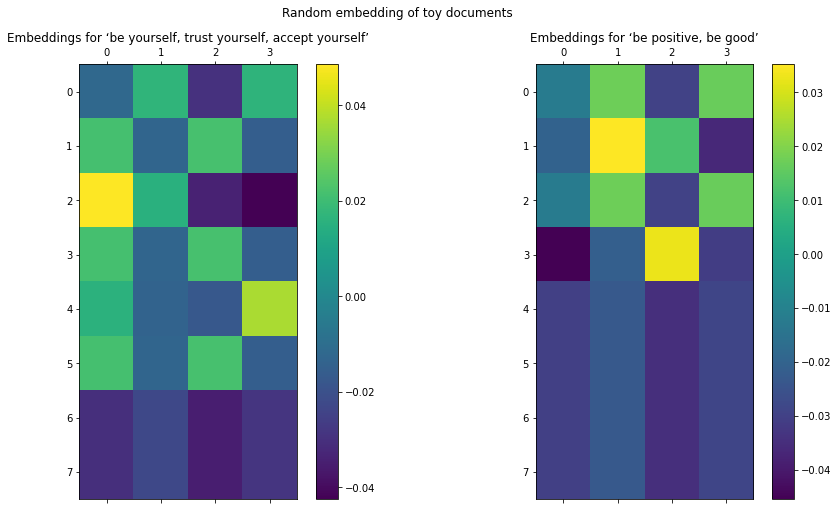

In [ ]:
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(toy_embedded_words.numpy()[0])
plt.gcf().colorbar(cax)   
plt.title('Embeddings for ‘be yourself, trust yourself, accept yourself’', y=1)
ax = plt.subplot(1, 2, 2) 
cax = ax.matshow(toy_embedded_words.numpy()[1])
plt.gcf().colorbar(cax)   
plt.title('Embeddings for ‘be positive, be good’', y=1)
fig.suptitle('Random embedding of toy documents')
plt.show()

In the graphic on the left, you can see that rows 1, 3, and 5 represent the word ‘yourself,’ and therefore are all the same. Same goes for the word 'be' as shown in rows 0 and 2 of the figure on the right. 

Next, let's look at the random embeddings of the two documents of the Newsgroup corpus that we loaded earlier. I have chosen these two documents arbitrarily.

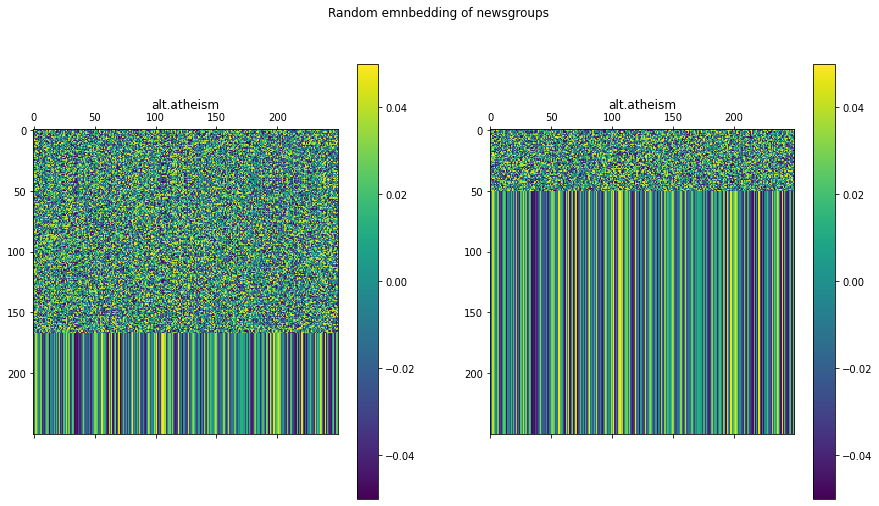

In [ ]:
docs_embedding_layer = Embedding(input_dim=docs_vocab_size+1, 
                                 output_dim=docs_output_seq_len)
docs_embedded_words = docs_embedding_layer(docs_vectorized_corpus[21:23])
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(docs_embedded_words.numpy()[0])
plt.gcf().colorbar(cax)     
plt.title(newsgroup_names[train_Y[21]])
ax = plt.subplot(1, 2, 2) 
cax = ax.matshow(docs_embedded_words.numpy()[1])
plt.gcf().colorbar(cax)   
plt.title(newsgroup_names[train_Y[22]])
fig.suptitle('Random emnbedding of newsgroups')
plt.show()

You can see that the first half of both embeddings matrices are random pixels. The stripes in the bottom half show the zero padding of the matrices. If you use this layer in a machine learning model pipeline, TensorFlow automatically learns the embeddings according to the training data. The image below is from a previous tutorial on [How to Build a Transformer for Supervised Classification Using Keras and TensorFlow](https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification-using-keras-and-tensorflow), which shows how word embeddings are learned when training a transformer.

![Random and Learned Embeddings](https://d2xo500swnpgl1.cloudfront.net/uploads/scale/some-file-473b28ce-f24a-44da-bf6e-98efa5a2e6e9-1653580547546.jpeg)

*Figure 2: Random and Learned Embeddings. Source: [How to Build a Transformer for Supervised Classification Using Keras and TensorFlow](https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification-using-keras-and-tensorflow).*

### Word Embeddings in Transformers: Attention is All You Need
One possible word embedding is described by Vaswani et al. in [Attention is All You Need](https://arxiv.org/abs/1706.03762), a seminal paper describing the transformer model. The authors convert a sentence corresponding to a sequence of words to an embedding matrix based on the sinusoid functions. An input sequence of length $L$ is mapped to a place in the row $i$ of the embedding matrix using the function $P$ given by:

\begin{eqnarray}
P(i, 2j)   &=& \sin\big(\frac{i}{n^{2j/d}}\big)\\
P(i, 2j+1) &=& \cos\big(\frac{i}{n^{2j/d}}\big)
\end{eqnarray}

Here:

$i$: Index of a word in the input sequence, $0 \leq i < L$.

$j$: Used for mapping to column indices with $0 \leq j < d/2$. In the expression $2j$ or $2j+1$ distinguishes an even index from an odd index.

$d$: Output embedding dimension or the number of columns of the embedding matrix. 

$j$: Index of the output embedded vector.

$P(k, j)$: Function that maps an index $k$ in the input word sequence to index $(k,j)$ of the output matrix. The even indices are mapped using a sine function and odd indices are mapped using a cosine function. 

$n$: Constant defined by the user. Its value is arbitrarily set to 10,000 by the authors of "Attention is All You Need." 

As the position of every word in a sequence is important, the preprocessing layer computes two embedding matrices. One matrix represents the word embeddings and the other represents an encoding of positions. The goal of the latter is to add positional information to the words. In this way, each sentence will have the same corresponding positional matrix but a different word embedding matrix. The final word embedding matrix input to the transformer is a sum of word and position embeddings.

#### Implementing Word Embedding in Python with Keras
Keras does not have a built-in method or layer to give you the sinusoidal word and position mapping. However, it is easy to write your own class that computes these embeddings. The code below shows how you can create your own `MyEmbeddingLayer` class by subclassing the Keras `Layer`. Following are a few important features of this class:

- The `get_encoding_matrix()` method computes the encoding matrix from the sine and cosine functions.
- The `embedding_layer_words` attribute defines an embedding layer with the `weights` parameter specifying the encoding matrix and the `trainable` parameter set to `False`. This layer will automatically take a word sequence and map it according to the specified weights (`embedding_matrix_words`).
- The `embedded_indices` attribute holds the embedding matrix for the position indices. As all sentences have the same position embeddings, you can store this matrix at initialization time. 

In [ ]:
class MyEmbeddingLayer(Layer):
    def __init__(self, seq_len, vocab_size, output_dim, n=10000, **kwargs):
        super(MyEmbeddingLayer, self).__init__(**kwargs)
        
        embedding_matrix_words = self.get_encoding_matrix(vocab_size, output_dim, n)                                                
        self.embedding_layer_words = Embedding(input_dim=vocab_size, 
                                               output_dim=output_dim,
                                               weights=[embedding_matrix_words],
                                               trainable=False
                                               )
        # Position embedding is same for all sentences so we can store these embeddings
        # at initialization time
        embedded_indices = self.get_encoding_matrix(seq_len, output_dim, n)   
        self.embedded_indices = convert_to_tensor(embedded_indices, dtype=float32)
                     
    def get_encoding_matrix(self, L, d, n):
        # Get a matrix Lxd of zeros
        encoding_matrix = np.zeros((L, d))
        for i in range(L):
            for j in np.arange(int(d/2)):
                denom = np.power(n, 2*j/d)
                encoding_matrix[i, 2*j] = np.sin(i/denom)
                encoding_matrix[i, 2*j+1] = np.cos(i/denom)
        return encoding_matrix


    def call(self, inputs):        
        embedded_words = self.embedding_layer_words(inputs)       
        return embedded_words + self.embedded_indices

Let's view the embeddings for the two toy sentences. To give you a better idea of this embedding, I have increased the size of the sequence length by using `pad_sequences()`, and increased the output dimension to 30 before rendering the embeddings as an image. 

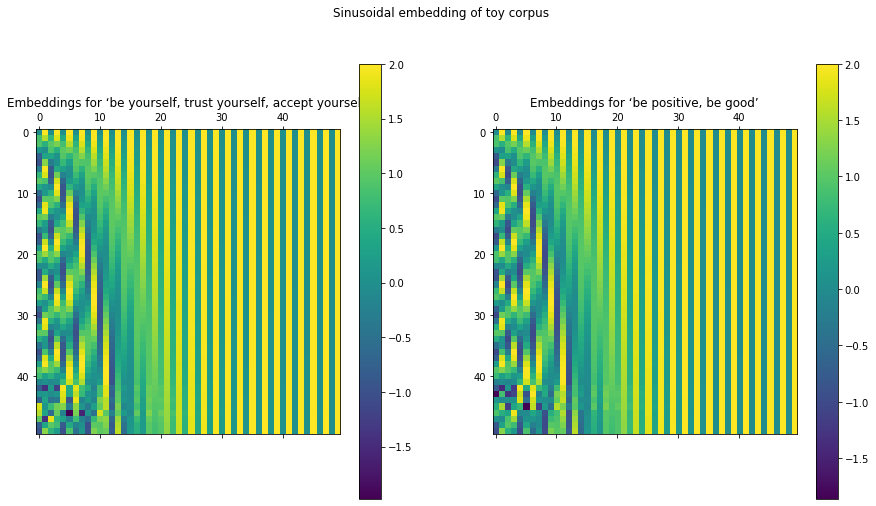

In [ ]:
# Get the sinusoidal embeddings
toy_vectors2 = pad_sequences(toy_vectorized_corpus, maxlen=50)
toy_embeddings_layer = MyEmbeddingLayer(seq_len=50, vocab_size=8, output_dim=50)
toy_sinusoid_embedding = toy_embeddings_layer(toy_vectors2)
# View the embeddings
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(toy_sinusoid_embedding.numpy()[0])
plt.gcf().colorbar(cax)   
plt.title('Embeddings for ‘be yourself, trust yourself, accept yourself’', y=1)
ax = plt.subplot(1, 2, 2) 
cax = ax.matshow(toy_sinusoid_embedding.numpy()[1])
plt.gcf().colorbar(cax)   
plt.title('Embeddings for ‘be positive, be good’', y=1)
plt.suptitle('Sinusoidal embedding of toy corpus')
plt.show()

Next, let's view the sinusoidal embeddings of the Newsgroups text. Here, I arbitrarily chose two documents to embed. Notice that the embeddings of both documents are different, giving them a unique signature.

In [ ]:
docs_embedding_layer = MyEmbeddingLayer(seq_len=docs_output_seq_len, vocab_size=docs_vocab_size, output_dim=300)
docs_sinusoid_words = docs_embedding_layer(docs_vectorized_corpus[40:42])

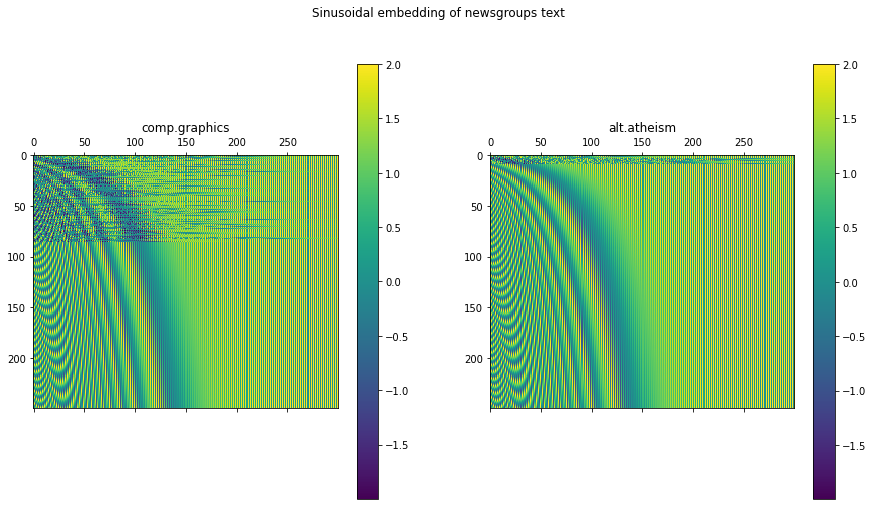

In [ ]:
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(docs_sinusoid_words.numpy()[0])
plt.gcf().colorbar(cax)   
plt.title(newsgroup_names[train_Y[40]], y=1)
ax = plt.subplot(1, 2, 2) 
cax = ax.matshow(docs_sinusoid_words.numpy()[1])
plt.gcf().colorbar(cax)   
plt.title(newsgroup_names[train_Y[41]], y=1)
plt.suptitle('Sinusoidal embedding of newsgroups text')
plt.show()

### Retrieving a Pre-Trained Embedding in TensorFlow

[TensorFlow Hub](https://tfhub.dev/), a repository of pre-trained models that you can use in your project, also contains a collection of text embeddings trained on different types of problems. It is a great resource if you don't want to spend time building or learning your own embeddings from scratch, and you also have the option of transfer learning by loading a pre-trained embedding and tuning it for your specific application. 

In the example below, I have loaded the [Universal Sentence Encoder model](https://tfhub.dev/google/universal-sentence-encoder/4) that has been trained on a large dataset from different sources, and can be used to solve various NLP tasks. This model converts an input word, sentence, or an entire document to a one-dimensional vector of embeddings.

You can explore various [TensorFlow pre-trained embeddings](https://tfhub.dev/s?module-type=text-embedding) and choose the one right for you. Effectively, all of these models have been built using the same protocol, so if you understand this example you'll better understand how to work with other pre-trained word embeddings in TensorFlow Hub.

The code below transforms the documents from alt.atheism and comp.graphics categories to their respective embeddings using the Universal Sentence Encoder model. Both embeddings are rendered as images. One row of the image represents one newsgroup document.

In [ ]:
# Import the embeddings as a Keraas layer
hub_sentence_encodings = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

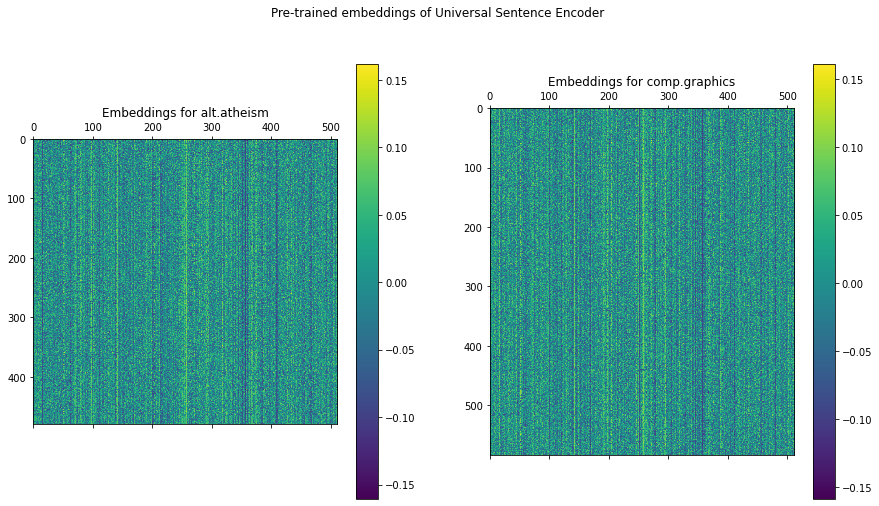

In [ ]:
# Separate the alt_atheism documents
ind_atheism = np.where(train_Y==0)[0]
alt_atheism = list(map(train_X.__getitem__, np.where(train_Y==0)[0]))
# Separate the comp.graphics documents
ind_graphics = np.where(train_Y==1)[0]
comp_graphics = list(map(train_X.__getitem__, ind_graphics))
# Embed both sets of documents
embeddings_graphics = hub_sentence_encodings(constant(comp_graphics))
embeddings_atheism = hub_sentence_encodings(constant(alt_atheism))
# Plot the embeddings
fig = plt.figure(figsize=(15, 8))   
ax = plt.subplot(1, 2, 1) 
cax = ax.matshow(embeddings_atheism.numpy())
plt.gcf().colorbar(cax)   
plt.title('Embeddings for alt.atheism', y=1)

ax = plt.subplot(1, 2, 2) 
cax = ax.matshow(embeddings_graphics.numpy())
plt.gcf().colorbar(cax)   
plt.title('Embeddings for comp.graphics', y=1)
plt.suptitle('Pre-trained embeddings of Universal Sentence Encoder')
plt.show()

Unlike random embeddings, you can see that the learned embeddings loaded from the Universal Sentence Encoder are much smoother. If you look closely enough, you'll notice that they are also different from each other for both Newsgroup categories.

#### Correlation Between Documents
To get an idea of the merits of learned embeddings of the Universal Sentence Encoder, look at the correlation between different documents. We expect correlations between documents of the same category to be high, and the correlation of documents between two different categories to be close to zero. 

While correlation values range from -1 to +1, I am taking their absolute value to approximate the magnitude of similarity between the documents from alt.atheism and comp.graphics. Also, printing the correlation values is of no use to us as it is simply a jumble of numbers. Instead, we render them as an image as shown in the code below.

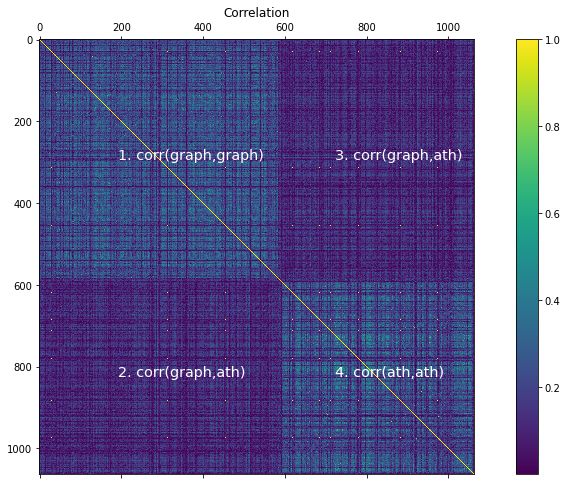

In [ ]:
ath_len = embeddings_atheism.shape[0]
graph_len = embeddings_graphics.shape[0]
# Compute correlations
sim = np.absolute(np.corrcoef(x=embeddings_graphics, y=embeddings_atheism))
# View the correlation matrix
fig = plt.figure(figsize=(15, 8))  
cax = plt.gca().matshow(sim)
plt.gcf().colorbar(cax)   
plt.title('Correlation', y=1)
x1 = graph_len/2
x2 = graph_len+ath_len/2
# Label the sub-matrices
_ = plt.text(x1-100,x1,'1. corr(graph,graph)', color='white', fontsize='x-large')
_ = plt.text(x1-100,x2,'2. corr(graph,ath)', color='white', fontsize='x-large')
_ = plt.text(x2-100,x1,'3. corr(graph,ath)', color='white', fontsize='x-large')
_ = plt.text(x2-100,x2,'4. corr(ath,ath)', color='white', fontsize='x-large')

In the correlation matrix above, the yellow diagonal represents the correlation of a document with itself, and has the maximum value of one. Also, there are four sub-matrices (labelled in the figure) for:

1. Correlation between documents of alt.atheism with documents of alt.atheism
1. Correlation between documents of comp.graphics with documents of alt.atheism
1. Correlation between documents of comp.graphics with documents of alt.atheism
1. Correlation between documents of comp.graphics with documents of comp.graphics

The correlations between documents of alt.atheism with correlation of documents from alth.atheism is close to zero, as indicated by the dark blue color. However, the correlation between the documents from the same categories has many lighter tones that indicate greater than zero values. While some documents within the same category have low correlations, the overall matrix shows a clear discrimination between the two categories of newsgroups.

## What's Next?
In this tutorial you learned the first steps for converting text to a format that can be used for further processing by a machine learning or pattern recognition algorithm. Understanding various text preprocessing techniques, including statistical metrics of text and word embeddings, is important for developing all types of NLP applications. How you preprocess text and the text representations you use will significantly affect the performance and accuracy of your end application. Now you are ready to set up your own NLP pipeline for the task at hand.

## Learn More
- [A Guide to Text Preprocessing Techniques for NLP](https://exchange.scale.com/public/blogs/preprocessing-techniques-in-nlp-a-guide)
- [How to Build a Transformer for Supervised Classification Using Keras and TensorFlow](https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification-using-keras-and-tensorflow)